Реализовать синтезирование лиц из LFW с помощью DCGAN  
Библиотеки: [Python, Tensorflow]

In [ ]:
%tensorflow_version 2.x

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
(train_ds, test_ds), ds_info = tfds.load(
    name='lfw',
    as_supervised=True, with_info=True, 
    split=['train[:99%]', 'train[99%:]']
)

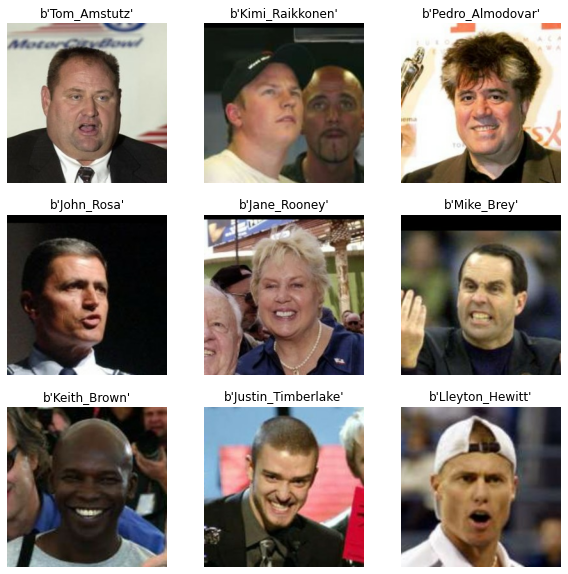

In [ ]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(train_ds.take(9)):
    plt.subplot(3, 3, i+1)
    plt.title(x[0].numpy())
    plt.imshow(x[1])
    plt.axis('off')

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [ ]:
ex_lbl, ex_img = next(iter(train_ds.take(1)))
np.min(ex_img), np.max(ex_img), ex_img.shape

(0, 255, TensorShape([250, 250, 3]))

In [ ]:
# Pipline imgs
INP_SIZE = 128
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare(label, img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5 # / 255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
# train_ds = train_ds.take(12800)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

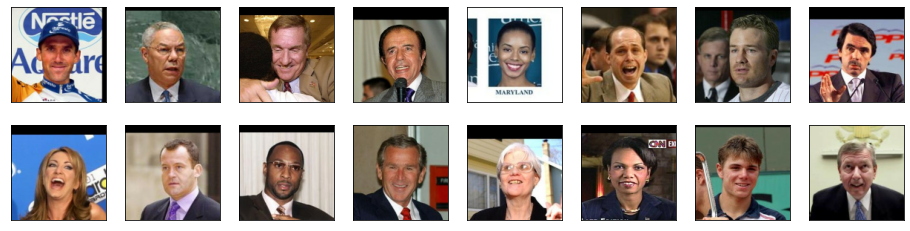

In [ ]:
fig = plt.figure(figsize=(16, 4))
j = 0
for batch in tfds.as_numpy(train_ds.take(1)):
    for image in batch:
        ax = fig.add_subplot(2, 8, j+1)
        ax.imshow((image+1)/2.)
        plt.xticks([]), plt.yticks([])
        j += 1
plt.show()


Deep Convolutional GAN (DCGAN)

In [ ]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    # tf.keras.layers.UpSampling2D((2, 2)),    
    # tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    # tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [ ]:
INPUT_DIM = 100
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def plot_faces(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(INP_SIZE, INP_SIZE, 3)+1)/2.)
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step   0] D Loss: 0.430823; G Loss: 1.736729


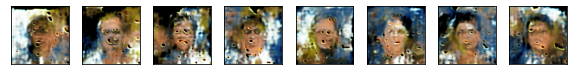

[Step 200] D Loss: 1.150852; G Loss: 0.788045


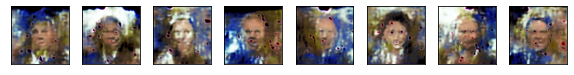

[Step 400] D Loss: 0.391670; G Loss: 2.603234


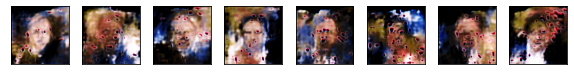

[Step 600] D Loss: 0.930177; G Loss: 0.608344


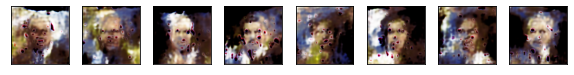

[Step 800] D Loss: 0.309801; G Loss: 3.264414


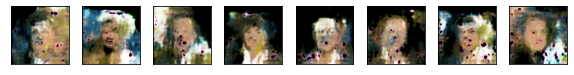

[Step 1000] D Loss: 0.082165; G Loss: 0.146163


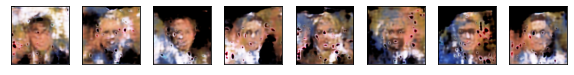

[Step 1200] D Loss: 0.645912; G Loss: 2.400322


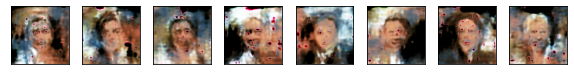

[Step 1400] D Loss: 0.068035; G Loss: 5.309935


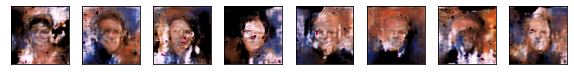

[Step 1600] D Loss: 0.325838; G Loss: 0.094400


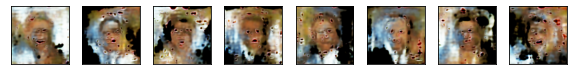

[Step 1800] D Loss: 0.618017; G Loss: 4.522558


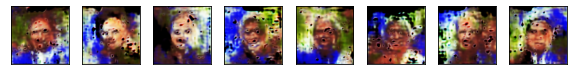

[Step 2000] D Loss: 1.090012; G Loss: 3.932566


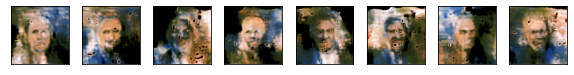

[Step 2200] D Loss: 0.197558; G Loss: 1.343409


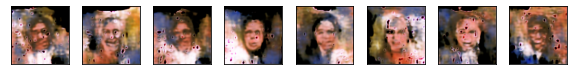

[Step 2400] D Loss: 0.630023; G Loss: 1.236044


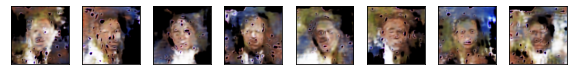

[Step 2600] D Loss: 0.164060; G Loss: 2.965287


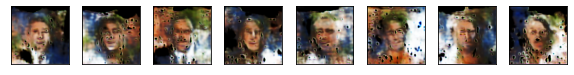

[Step 2800] D Loss: 0.344611; G Loss: 3.490931


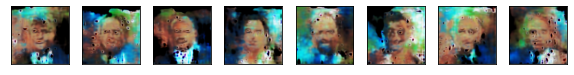

[Step 3000] D Loss: 0.487197; G Loss: 5.147151


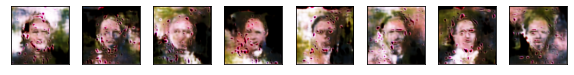

[Step 3200] D Loss: 0.091733; G Loss: 5.813948


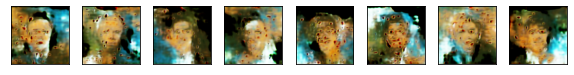

[Step 3400] D Loss: 0.267461; G Loss: 4.210207


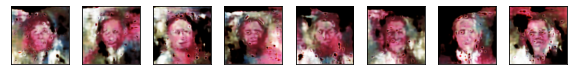

[Step 3600] D Loss: 0.446294; G Loss: 1.597238


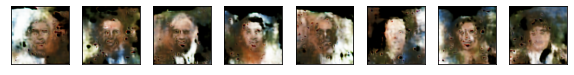

[Step 3800] D Loss: 0.092807; G Loss: 4.238854


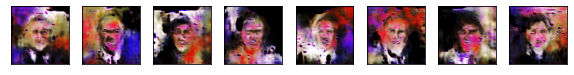

[Step 4000] D Loss: 1.094770; G Loss: 1.475366


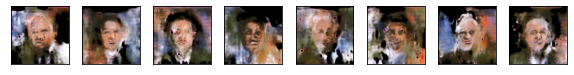

[Step 4200] D Loss: 0.548991; G Loss: 0.233750


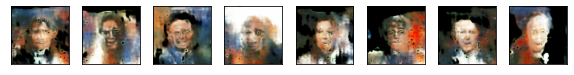

[Step 4400] D Loss: 0.249302; G Loss: 1.878272


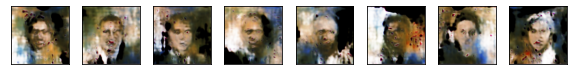

[Step 4600] D Loss: 0.092573; G Loss: 3.647882


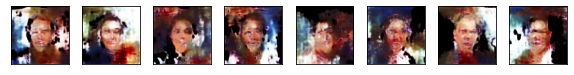

[Step 4800] D Loss: 0.258779; G Loss: 2.305458


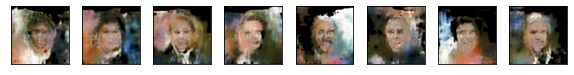

[Step 5000] D Loss: 0.068234; G Loss: 4.526913


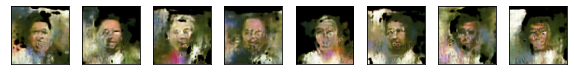

[Step 5200] D Loss: 0.221025; G Loss: 3.651554


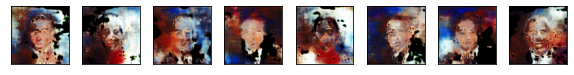

[Step 5400] D Loss: 1.330161; G Loss: 0.662750


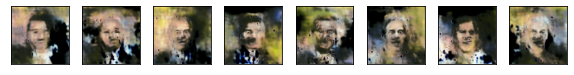

[Step 5600] D Loss: 0.213145; G Loss: 2.124754


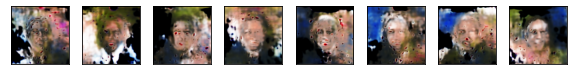

[Step 5800] D Loss: 0.024141; G Loss: 4.790676


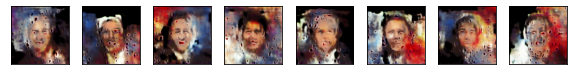

[Step 6000] D Loss: 0.199935; G Loss: 1.433736


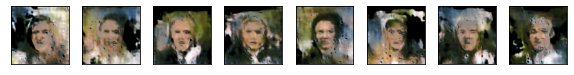

[Step 6200] D Loss: 0.343424; G Loss: 2.207594


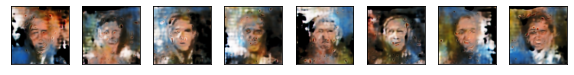

[Step 6400] D Loss: 0.388755; G Loss: 1.079087


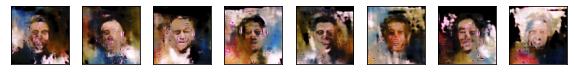

[Step 6600] D Loss: 0.278211; G Loss: 3.025104


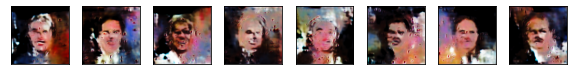

[Step 6800] D Loss: 0.090671; G Loss: 3.338032


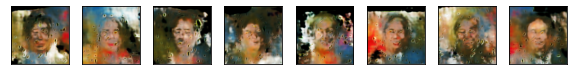

[Step 7000] D Loss: 0.519402; G Loss: 4.713385


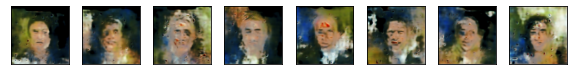

[Step 7200] D Loss: 0.684625; G Loss: 3.359014


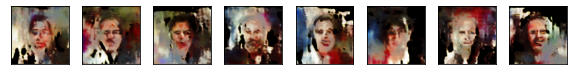

[Step 7400] D Loss: 0.169380; G Loss: 4.077444


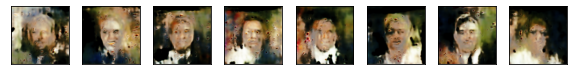

[Step 7600] D Loss: 0.401839; G Loss: 3.870651


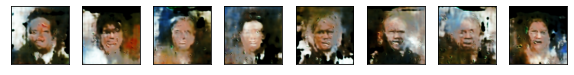

[Step 7800] D Loss: 0.043330; G Loss: 5.139692


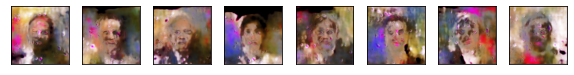

[Step 8000] D Loss: 0.724270; G Loss: 1.213166


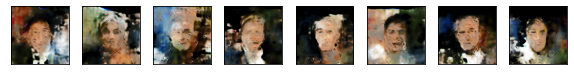

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    # print(syntetic_images.shape, true_images.shape)
    # break
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))  
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator   
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)   
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results  
    if step % 200 == 0:
        print('[Step %3d] D Loss: %.6f; G Loss: %.6f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)

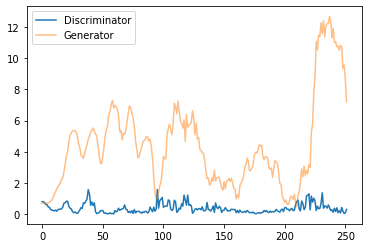

In [ ]:
plt.plot(d_loss, label="Discriminator")
plt.plot(g_loss, label="Generator", alpha=0.5)
plt.legend()

Тестирование свёрточного генератора

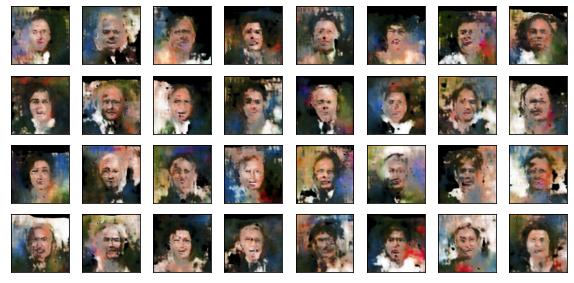

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

Интерполяция в латентном пространстве

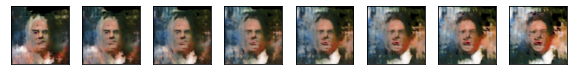

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)